# Transfer Learning Part 3: Scaling up
In this section, a larger dataset will be used and trained upon. The baseline to beat in is the original Food101 paper 
The mode had 50.76% accuracy across 101 classes.

In [1]:
# Load the helper module
import sys
sys.path.append("../helper")

from helperFunctions import walk_through_dir, plot_loss_curves, create_tensorboard_callback, compare_historys, custom_imgs

The first model will use 10% of the data with 101 food classes

In [2]:
# How many images/classes are there?
walk_through_dir("./101_food_classes_10_percent")

There are 2 directories and 0 images in './101_food_classes_10_percent'.
There are 101 directories and 0 images in './101_food_classes_10_percent\test'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in './101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories

In [3]:
# Set up the directories
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [4]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size= IMG_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False) # Temporarily false

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of the 101 food classes dataset
Steps to be taken:
- Create a ModelCheckpoint callback 
- Create a data augmentation to build data augmentation right into the model
- Build a headless (no top layers) Functional (EfficientNetB0) backboned-model (create your own output)
- Compile the model
- Feature extract for 5 full passes (5 epochs on training and validation on 15% of test data)

In [6]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [7]:
# Create data augmentation layer to incorporate it right into the model

# Note that Pylance has issues with the dynamnic api of TensorFlow
# Hence, to keep its functionality keras is imported directly.
# Version 2.6 uses different methods such as layer.experimental 
# However, version 2.9 will likely work again with Pylance as
# tensorflow.keras etc.
import keras
from keras import layers
from keras import Sequential
from keras import Model



In [8]:
# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomRotation(0.2),
    # layers.Rescaling(1/255) # Rescale inputs if needed between 0 & 1
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (extracts its features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Creating the model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only during training phase)
x = base_model(x, training=False) # base model in inference mode (weights intended to stay frozen stays frozen)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = Model(inputs, outputs)

In [10]:
# Get a summary of the create model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Comiple the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Fit the model
history_10_percent_data = model.fit(train_data_10_percent,
                                    epochs=5, 
                                    validation_data=test_data,
                                    validation_steps=int(0.15*len(test_data)), 
                                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 127s 485ms/step - loss: 3.4722 - accuracy: 0.2478 - val_loss: 2.6961 - val_accuracy: 0.3822
Epoch 2/5
237/237 [==============================] - 87s 369ms/step - loss: 2.3496 - accuracy: 0.4553 - val_loss: 2.2381 - val_accuracy: 0.4587
Epoch 3/5
237/237 [==============================] - 78s 330ms/step - loss: 1.9976 - accuracy: 0.5283 - val_loss: 2.0554 - val_accuracy: 0.4828
Epoch 4/5
237/237 [==============================] - 71s 299ms/step - loss: 1.7825 - accuracy: 0.5700 - val_loss: 1.9805 - val_accuracy: 0.4947
Epoch 5/5
237/237 [==============================] - 72s 305ms/step - loss: 1.6140 - accuracy: 0.6042 - val_loss: 1.9730 - val_accuracy: 0.4889


In [12]:
# Evaluate the mode over the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 81s 102ms/step - loss: 1.7212 - accuracy: 0.5491


[1.721157193183899, 0.5490692853927612]

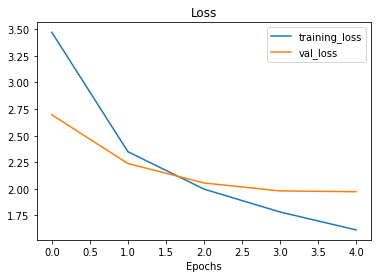

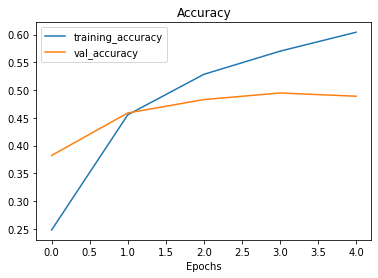

In [13]:
# Plot the loss curves to visualize the losses
plot_loss_curves(history_10_percent_data)

The validation curves appears to follow a different trernd. This could indicate overfitting of the model.

However, the first model has already beaten the baseline of the paper!

## Fine-tuning the model

In [14]:
# Unfreeze all the layers in the base model
base_model.trainable = True

# Keep the last 5 layers only unfrozen (you can pick as many 
# as you want, however, the model is doing fairly well in this case)
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [15]:
# Recomiple the model with lower learning 
# Typically, it's best practice to lower it during fine tuning
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])



In [16]:
# What layers are trainable in the model?
# Notice efficientnet is True since it has 5 trainable layers
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# Check which layers are trainable in the base model:
for layer_num, layer in enumerate(model.layers[2].layers):
    print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [18]:
# Fine-tune the model for 5 more epochs
fine_tune_epochs = 10

# Fit the model
history_10_percent_data_fine_tune = model.fit(train_data_10_percent,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.15*len(test_data)),
                                                initial_epoch=history_10_percent_data.epoch[-1])

Epoch 5/10
237/237 [==============================] - 82s 281ms/step - loss: 1.3861 - accuracy: 0.6401 - val_loss: 1.9420 - val_accuracy: 0.4921
Epoch 6/10
237/237 [==============================] - 61s 256ms/step - loss: 1.2857 - accuracy: 0.6606 - val_loss: 1.9569 - val_accuracy: 0.4936
Epoch 7/10
237/237 [==============================] - 61s 255ms/step - loss: 1.1910 - accuracy: 0.6886 - val_loss: 1.9144 - val_accuracy: 0.5032
Epoch 8/10
237/237 [==============================] - 58s 245ms/step - loss: 1.1406 - accuracy: 0.6994 - val_loss: 1.9414 - val_accuracy: 0.4963
Epoch 9/10
237/237 [==============================] - 58s 246ms/step - loss: 1.0843 - accuracy: 0.7143 - val_loss: 1.8773 - val_accuracy: 0.5106
Epoch 10/10
237/237 [==============================] - 54s 226ms/step - loss: 1.0040 - accuracy: 0.7395 - val_loss: 1.8688 - val_accuracy: 0.5169


In [19]:
# Evaluate the whole test data
fine_tuning_results_unfrozen = model.evaluate(test_data)

790/790 [==============================] - 79s 100ms/step - loss: 1.6147 - accuracy: 0.5753


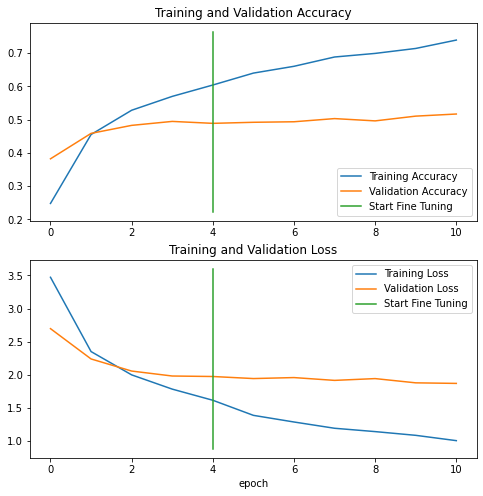

In [20]:
# Compare the fine-tuned model to the initial model
compare_historys(history_10_percent_data, history_10_percent_data_fine_tune)

### Save and load the fine-tuned model
- To use the model for external applications, try using it again after reloading it in.

In [21]:
model.layers[0]._name = "input_layer"

In [22]:
# NOTE: If an error occurs regarding a layer name
# Find the model using model.layers and rename it
# E.g model.layers[0]._name = "input_layer" (was called: input layer)
model.save("./101_food_classes_10_percent_big_dog_model/")

INFO:tensorflow:Assets written to: ./101_food_classes_10_percent_big_dog_model/assets


In [5]:
# Evaluate the loaded model and compare performance
loaded_model = tf.keras.models.load_model("./101_food_classes_10_percent_big_dog_model/")
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 93s 108ms/step - loss: 1.6147 - accuracy: 0.5753


In [24]:
# Compare the results before it was loaded
# The only difference is found due to the precision
fine_tuning_results_unfrozen

[1.6146769523620605, 0.5753267407417297]

### Evaluating the performance of the big dog model across all different classes
- Perform some predictions, visualize them and see which ones are the most wrong

In [25]:
# Load in the saved model that was made previously
loaded_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model/")

In [26]:
# The errors above have been fixed in the later tensorflow models
# and can be ignored. 
# The loaded model appears to perform similarly.

# Evaluate the loaded model
results_downloaded_model = loaded_model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 81s 101ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027207851409912, 0.6077623963356018]

### Making predictions with the trained model

In [15]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set to 1 to see the time left

790/790 [==============================] - 82s 103ms/step


In [28]:
# How many predictions are there?
# What is the shape of each prediction?
len(preds_probs), preds_probs.shape

(25250, (25250, 101))

In [29]:
# Each value has probabilities for each class
preds_probs[0], len(preds_probs[0])

(array([3.92911255e-01, 2.98732957e-05, 1.31125882e-01, 1.25870315e-07,
        5.97420330e-06, 4.11039400e-06, 8.55877370e-05, 1.20474087e-05,
        4.75957468e-02, 3.66113556e-04, 2.82183646e-06, 1.02719632e-05,
        3.06262309e-03, 1.92284278e-06, 1.68792997e-02, 2.73786345e-03,
        3.25780784e-05, 1.41353637e-03, 2.20564497e-03, 5.15477313e-06,
        5.10853541e-04, 1.86867637e-05, 2.30497026e-04, 2.67136289e-04,
        2.86250695e-04, 2.77679530e-04, 5.26401680e-04, 4.97821093e-05,
        3.52908410e-02, 2.22089072e-03, 6.98082249e-06, 2.36443267e-03,
        1.91363483e-03, 1.34835815e-07, 9.05477628e-03, 3.61589664e-05,
        2.54660263e-04, 7.12786801e-04, 9.12464559e-02, 1.33144767e-05,
        6.86464948e-04, 9.67921107e-04, 7.16890092e-04, 2.71005192e-05,
        9.80740588e-05, 1.43667086e-04, 4.43489058e-04, 8.07674078e-04,
        9.79561833e-07, 1.61583349e-02, 6.57186902e-04, 1.01041747e-04,
        1.93312764e-02, 1.11541739e-02, 2.90880635e-05, 1.223290

In [16]:
# Recreate what the model does to predict the type
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"The class with the highest predicted probability by the model \
    by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
The class with the highest predicted probability by the model     by the model for sample 0: 0


In [17]:
test_data.class_names[0]

'apple_pie'

In [18]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8, 29, 78, 29,  0,  0,  0], dtype=int64)

In [19]:
# To get the test labels the test_data needs to be unbatched
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
# How many labels are there?
len(y_labels)

25250

### Evaluating the model's predictions
One way to check the model's predictions array is keeping it in the same order as the test label arrays

In [35]:
fine_tuning_results_unfrozen

[1.6146769523620605, 0.5753267407417297]

In [36]:
# Try scikit-learn's accuracy score function 
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)

sklearn_accuracy

0.5753267326732673

In [37]:
# Does this metric come close to the model's results?
import numpy as np 
np.isclose(fine_tuning_results_unfrozen[1], sklearn_accuracy)

True

Visualize it with a confusion matrix

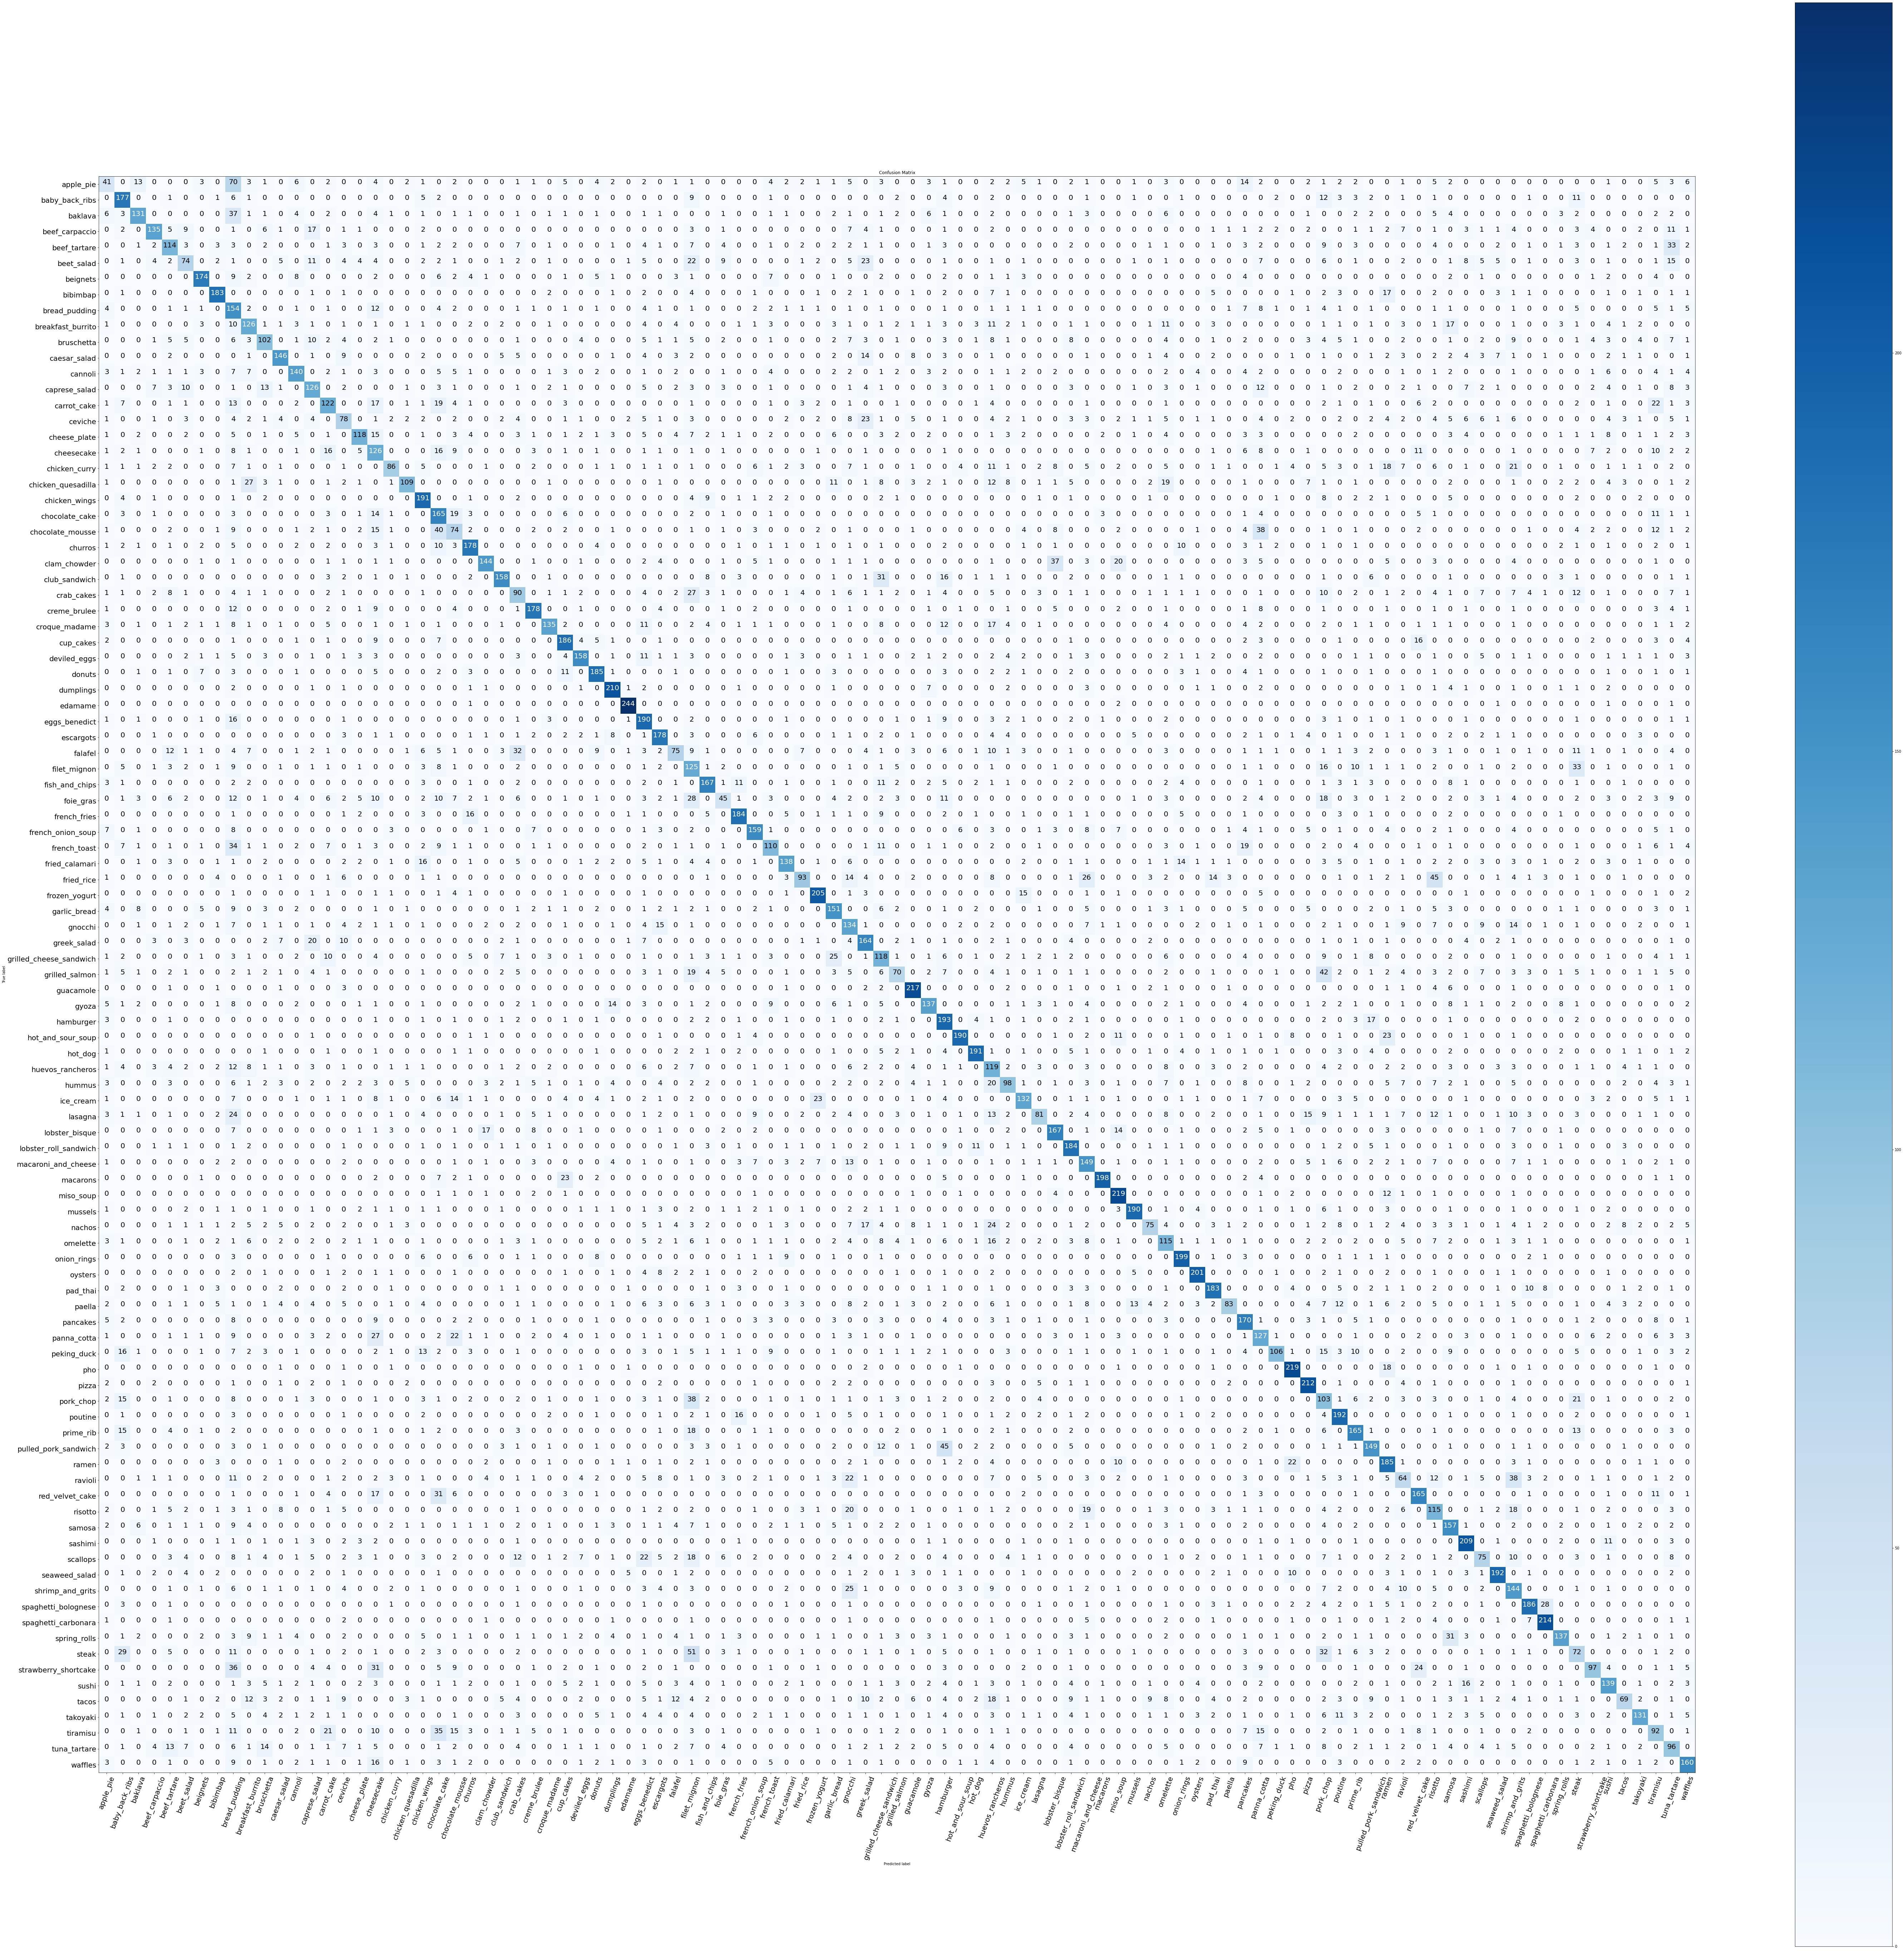

In [38]:
from helperFunctions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True,
                      rotate=True)

### Keep the evaluation train going and perform a classification report
- For this case sklearn.metrics.classification_report is useful.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                                y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.16      0.21       250
           1       0.54      0.71      0.62       250
           2       0.70      0.52      0.60       250
           3       0.76      0.54      0.63       250
           4       0.49      0.46      0.47       250
           5       0.47      0.30      0.36       250
           6       0.80      0.70      0.75       250
           7       0.80      0.73      0.76       250
           8       0.21      0.62      0.31       250
           9       0.51      0.50      0.51       250
          10       0.52      0.41      0.46       250
          11       0.70      0.58      0.64       250
          12       0.68      0.56      0.61       250
          13       0.51      0.50      0.51       250
          14       0.51      0.49      0.50       250
          15       0.37      0.31      0.34       250
          16       0.71      0.47      0.57       250
          17       0.30    

In [21]:
classification_report_dict = classification_report(y_labels, pred_classes,
                                                        output_dict=True)
classification_report_dict

{'0': {'precision': 0.3106060606060606,
  'recall': 0.164,
  'f1-score': 0.21465968586387438,
  'support': 250},
 '1': {'precision': 0.5446153846153846,
  'recall': 0.708,
  'f1-score': 0.6156521739130435,
  'support': 250},
 '2': {'precision': 0.7043010752688172,
  'recall': 0.524,
  'f1-score': 0.6009174311926606,
  'support': 250},
 '3': {'precision': 0.7584269662921348,
  'recall': 0.54,
  'f1-score': 0.6308411214953271,
  'support': 250},
 '4': {'precision': 0.4935064935064935,
  'recall': 0.456,
  'f1-score': 0.474012474012474,
  'support': 250},
 '5': {'precision': 0.4713375796178344,
  'recall': 0.296,
  'f1-score': 0.36363636363636365,
  'support': 250},
 '6': {'precision': 0.8018433179723502,
  'recall': 0.696,
  'f1-score': 0.7451820128479656,
  'support': 250},
 '7': {'precision': 0.7991266375545851,
  'recall': 0.732,
  'f1-score': 0.7640918580375782,
  'support': 250},
 '8': {'precision': 0.20671140939597316,
  'recall': 0.616,
  'f1-score': 0.30954773869346736,
  'suppor

In [22]:
# Plot the F1-scores

class_f1_scores = {}
# Loop through the dictionary items and pair it with the name
for k, v in classification_report_dict.items():
    if k == "accuracy":
        break
    else:
        class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.21465968586387438,
 'baby_back_ribs': 0.6156521739130435,
 'baklava': 0.6009174311926606,
 'beef_carpaccio': 0.6308411214953271,
 'beef_tartare': 0.474012474012474,
 'beet_salad': 0.36363636363636365,
 'beignets': 0.7451820128479656,
 'bibimbap': 0.7640918580375782,
 'bread_pudding': 0.30954773869346736,
 'breakfast_burrito': 0.5080645161290323,
 'bruschetta': 0.45535714285714285,
 'caesar_salad': 0.6375545851528385,
 'cannoli': 0.6140350877192982,
 'caprese_salad': 0.5050100200400801,
 'carrot_cake': 0.4989775051124744,
 'ceviche': 0.33986928104575165,
 'cheese_plate': 0.5673076923076923,
 'cheesecake': 0.37388724035608306,
 'chicken_curry': 0.4611260053619303,
 'chicken_quesadilla': 0.5647668393782384,
 'chicken_wings': 0.6858168761220826,
 'chocolate_cake': 0.4925373134328358,
 'chocolate_mousse': 0.3057851239669421,
 'churros': 0.6994106090373281,
 'clam_chowder': 0.6620689655172414,
 'club_sandwich': 0.7006651884700665,
 'crab_cakes': 0.3696098562628337,
 'creme_br

In [23]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [43]:
f1_scores

class_names  f1-score
33              edamame  0.956863
63             macarons  0.866521
91  spaghetti_carbonara  0.832685
69              oysters  0.825462
75                  pho  0.820225
..                  ...       ...
22     chocolate_mousse  0.305785
82              ravioli  0.291572
93                steak  0.289738
39            foie_gras  0.251397
0             apple_pie  0.214660

[101 rows x 2 columns]

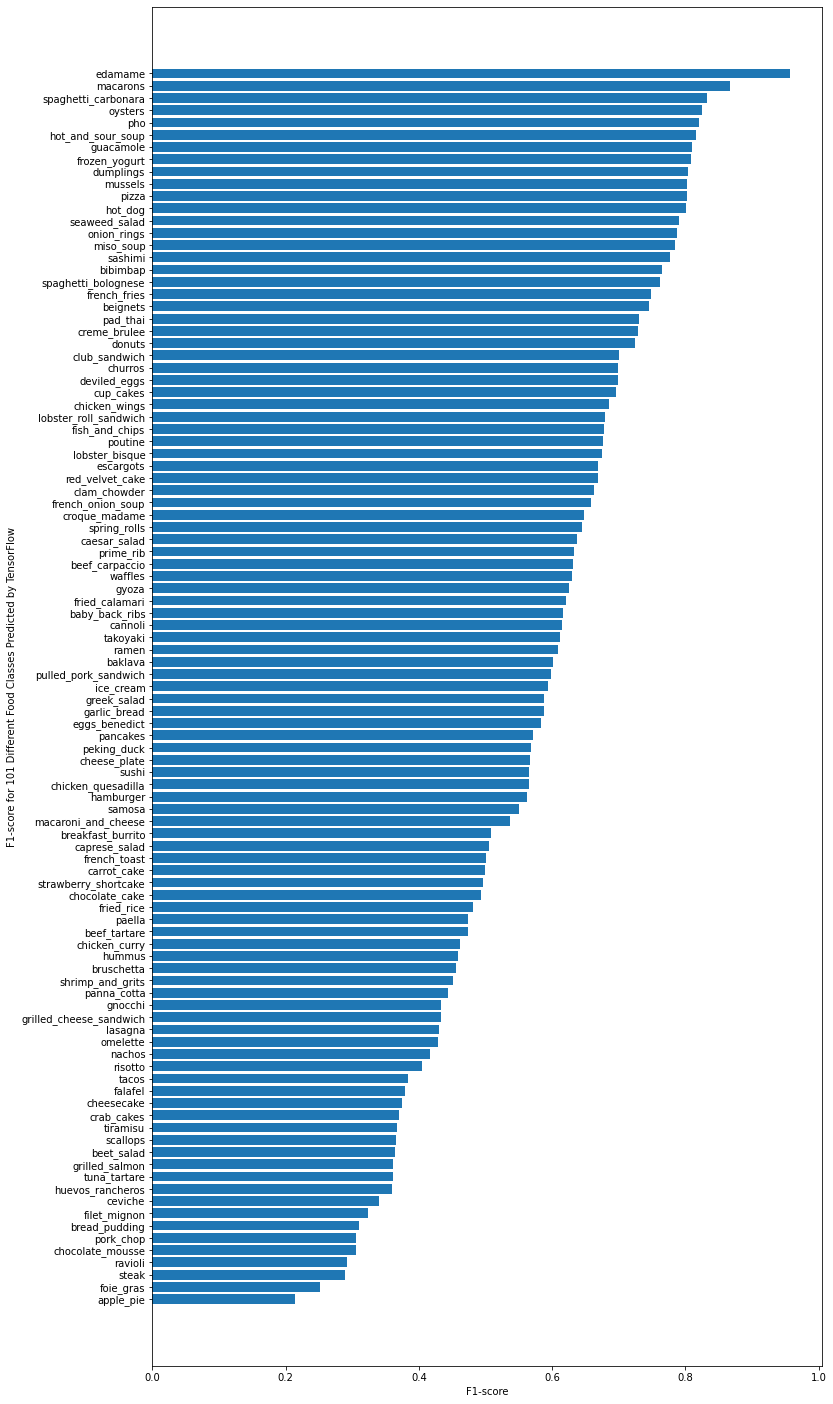

In [44]:
# f1_scores.plot(kind="bar")
import matplotlib.pyplot as plt

fig, ax, = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-score")
ax.set_ylabel("F1-score for 101 Different Food Classes Predicted by TensorFlow")
ax.invert_yaxis();

# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
#             f"{height}",
#             ha='center', va="bottom")
# autolabel(scores)

### Visualize custom images of the prediction 
A function will be needed to load and preprocess the data with the following functionalities:
- Read in a target image filepath using tf.io_read_file()
- Turn the image into a Tensor using tf.io.decode_image()
- Resize the image tensor to be the same size as the images the model has trained on using tf.image.resize()
- Scale the image ot get all the pixel values between 0 & 1 (if necessary, for this model using efficientnet it isn't)

In [45]:
# Create a function to load and prepare images (is already in helperFunctions)
def load_and_prep(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor 
    and reshapes specified shape (img_Shape, img_shape, collor_channels=3)
    Args:
        filename (str): path to target image
        img_shape (int, optional): height/width of the target img size. Defaults to 224.
        scale (bool, optional): scale pixels from 0-255 to 0-1. Defaults to True.
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Whether to scale the image or not
    if scale:
        # Rescale the image
        return img/255
    else:
        return img 

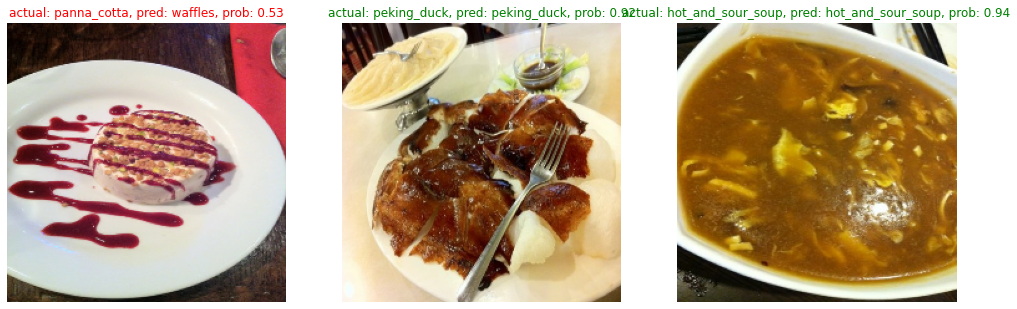

In [46]:
# Make predictions on a series of random images
import os 
import random

plt.figure(figsize=(17,10))
for i in range(3):
    # Choose a random image from a random class
    class_name = random.choice(f1_scores["class_names"])
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep(filepath, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = f1_scores["class_names"][pred_prob.argmax()]

    # Plot the Image
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

## Finding the most wrong predictions
Find the classes on which the model is most wrong. This could lead to insights on improving the model such as wrong labels, confusinbg labels (might want to merge labels) and so on.

1. Get all the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from the model), max prediction probabilities
3. Use the DataFrame to find all the wrong predictions
4. Sort the DataFrame based on wrong predictions (descending order)
5. Visualize the images with the highest prediction probabilities but habe the wrong predictions

In [7]:
# 1. Get all the image file paths of the test dataset
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    # Appends it as tensors so turn it to numpy
    filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [24]:
class_names = list(f1_scores["class_names"].unique())
len(class_names)

101

In [89]:
# 2. Create a DataFrame of different parameters for each test image type
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # Get the max probability predicted
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classnames": [class_names[i] for i in pred_classes]})

In [90]:
# 3. Find the prediction are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0       8   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0      29   

   pred_conf y_true_classname y_pred_classnames  pred_correct  
0   0.392911          edamame           edamame          True  
1   0.886089          edamame           edamame          True  
2   0.237833          edamame           edamame          True  
3   0.213669          edamame         dumplings         False  
4   0.486444          edamame    fish_and_chips         False

In [91]:
# 4. Sort the DataFrame to have the most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent\\test\\sushi\\16...      95      86   
23631  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
20214  b'101_food_classes_10_percent\\test\\pulled_po...      80      53   
22203  b'101_food_classes_10_percent\\test\\seaweed_s...      88      51   
11642  b'101_food_classes_10_percent\\test\\garlic_br...      46      10   
...                                                  ...     ...     ...   
8794   b'101_food_classes_10_percent\\test\\escargots...      35      41   
14585  b'101_food_classes_10_percent\\test\\ice_cream...      58      45   
14691  b'101_food_classes_10_percent\\test\\ice_cream...      58      79   
11063  b'101_food_classes_10_percent\\test\\fried_ric...      44      62   
15893  b'101_food_classes_10_percent\\test\\macarons\...      63       6   

       pred_conf    y_true_classname  y_pred_classnames  pred_correct  
23797   0.998948           pork_chop           tiramisu         False  
23631   0.998049       bread_pudding            falafel         False  
20214   0.996232              nachos      eggs_benedict         False  
22203   0.995959          beet_salad        greek_salad         False  
11642   0.995480            takoyaki              pizza         False  
...          ...                 ...                ...           ...  
8794    0.959722   french_onion_soup            waffles         False  
14585   0.959351  chicken_quesadilla            cannoli         False  
14691   0.959118  chicken_quesadilla           omelette         False  
11063   0.958800      baby_back_ribs  breakfast_burrito         False  
15893   0.958553       caprese_salad          guacamole         False  

[100 rows x 7 columns]

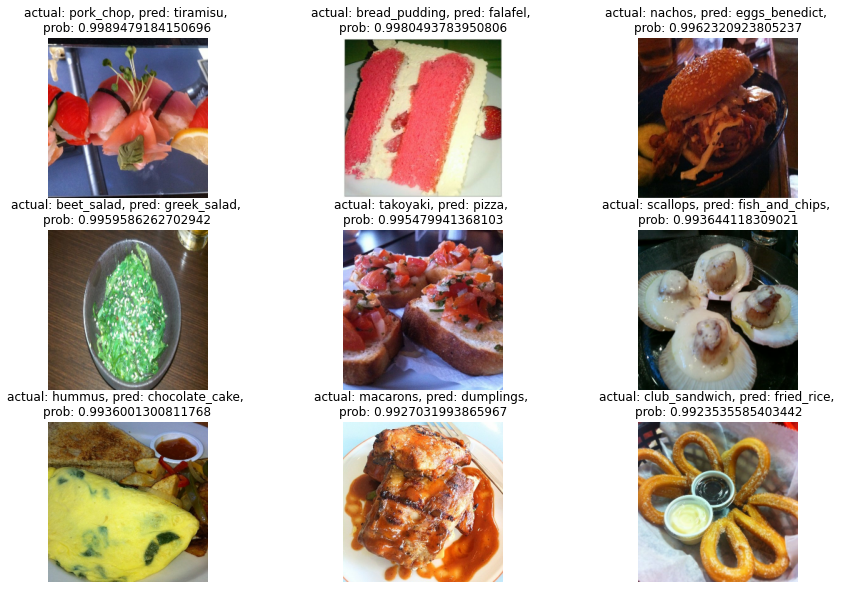

In [93]:
# 5. Visualize the test data samples with wrong prediction and have the highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # Only selecting few params in each row
    plt.imshow(img/255)
    plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
    plt.axis(False)

### Use the custom food images to predict on with the model

In [6]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

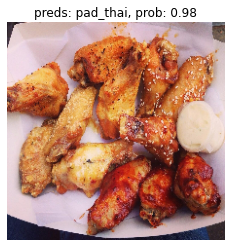

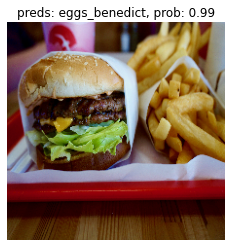

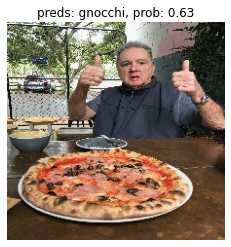

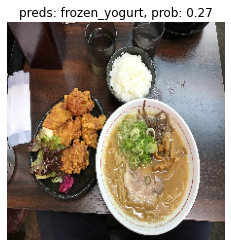

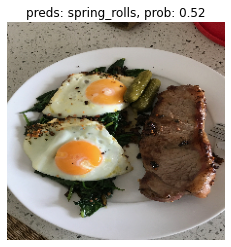

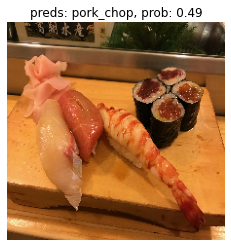

In [96]:
# Make predictions and plot the custom food images
for img in custom_food_images:
    img = load_and_prep(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    # Plot the appropriate information
    plt.figure()
    plt.imshow(img/255)
    plt.title(f"preds: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)

# Avoid reloading everything:

In [4]:
# Load the helper module
import sys
sys.path.append("../helper")

from helperFunctions import walk_through_dir, plot_loss_curves, create_tensorboard_callback, compare_historys, custom_imgs


# Set up the directories
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

# Prepare the train and test data
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size= IMG_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False) # Temporarily false

# Load the model and make predictions with it
loaded_model = tf.keras.models.load_model("./101_food_classes_10_percent_big_dog_model/")
preds_probs = loaded_model.predict(test_data, verbose=1) # set to 1 to see the time left

# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# To get the test labels the test_data needs to be unbatched
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # 

# Sklearning classification report 
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, pred_classes,
                                                        output_dict=True)

# Creating the DataFrame
class_f1_scores = {}
# Loop through the dictionary items and pair it with the name
for k, v in classification_report_dict.items():
    if k == "accuracy":
        break
    else:
        class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
class_names = list(f1_scores["class_names"].unique())

### For additional retuning on the model if necessary
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.
790/790 [==============================] - 77s 96ms/step


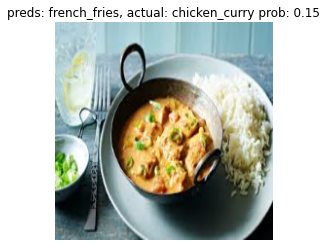

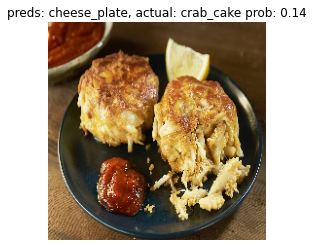

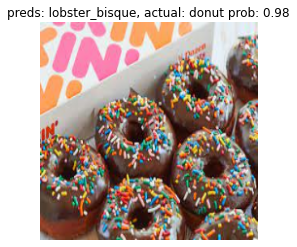

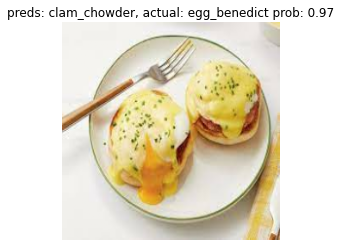

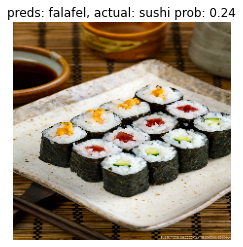

In [10]:
imgs_path = "custom_food_imgs"
custom_imgs(imgs_path, loaded_model, class_names, name_it=True)

## Fine-tune the model even further

In [13]:
# Load the previous model
model_3_tuned = tf.keras.models.load_model("./101_food_classes_10_percent_big_dog_model/")

# Revert it the state before fine-tuning
model_3_tuned.load_weights("101_classes_10_percent_data_model_checkpoint")

In [24]:
# Check if the object are trainable
for layer in model_3_tuned.layers:
    print(f"{layer.name} trainable: {layer.trainable}")

input_layer trainable: True
data_augmentation trainable: True
efficientnetb0 trainable: True
global_avg_pool_layer trainable: True
output_layer trainable: True


In [29]:
for i, layer in enumerate(model_3_tuned.layers[2].layers):
    print(f"{i}. {layer.name} trainable: {layer.trainable}")

0. input_1 trainable: True
1. rescaling trainable: False
2. normalization trainable: False
3. stem_conv_pad trainable: False
4. stem_conv trainable: False
5. stem_bn trainable: False
6. stem_activation trainable: False
7. block1a_dwconv trainable: False
8. block1a_bn trainable: False
9. block1a_activation trainable: False
10. block1a_se_squeeze trainable: False
11. block1a_se_reshape trainable: False
12. block1a_se_reduce trainable: False
13. block1a_se_expand trainable: False
14. block1a_se_excite trainable: False
15. block1a_project_conv trainable: False
16. block1a_project_bn trainable: False
17. block2a_expand_conv trainable: False
18. block2a_expand_bn trainable: False
19. block2a_expand_activation trainable: False
20. block2a_dwconv_pad trainable: False
21. block2a_dwconv trainable: False
22. block2a_bn trainable: False
23. block2a_activation trainable: False
24. block2a_se_squeeze trainable: False
25. block2a_se_reshape trainable: False
26. block2a_se_reduce trainable: False
27.

In [30]:
import tensorflow as tf
import keras
from keras import layers
from keras import Sequential
from keras import Model

In [34]:
# Fine-tune and change 2 extra layers to be unfrozen
model_3_tuned.trainable = True
for layer in model_3_tuned.layers[2].layers[:-7]:
    layer.trainable = False

In [ ]:
# Compile the model
model_3_tuned.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
                        metrics=["accuracy"]

# Fit the model
history_3_extra = model_3_tuned.fit(train_data_10_percent,
                                    epochs=10,
                                    )